### Import libraries and datasets:

In [96]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [97]:
csv_fts = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\FTS Historical Data.csv"
csv_mwg = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\MWG Historical Data.csv"
csv_vic = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\VIC Historical Data.csv"


df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [98]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


- Split Price data
- Reset index

In [99]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788.4
1,5953.7
2,6024.6
3,5882.9
4,6001.0


- Scale data between 0 and 1:

In [100]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003587
2,0.005125
3,0.002051
4,0.004613


- Split data into train, test, val (7 - 2 - 1):

In [101]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


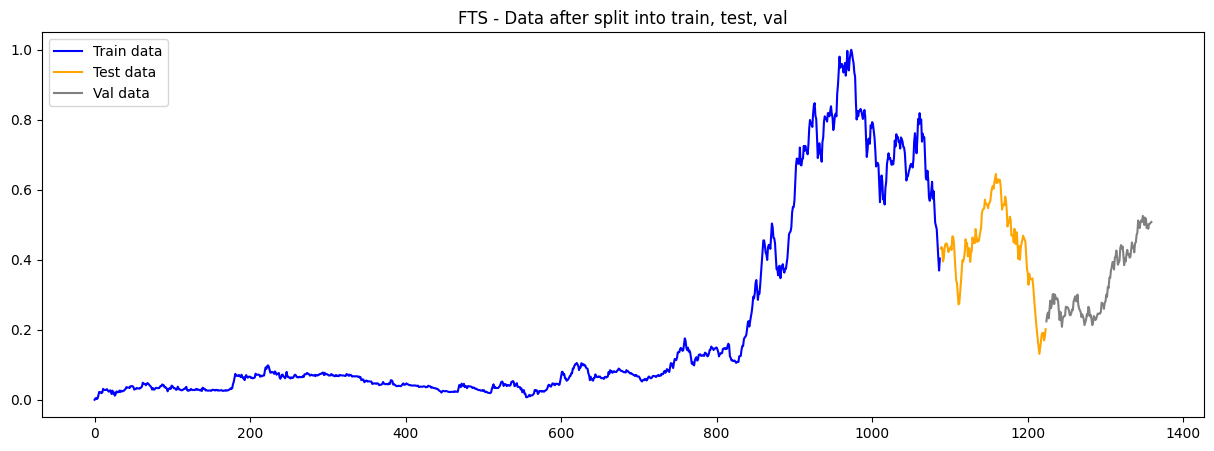

In [102]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [103]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [104]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [105]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [106]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(x_val.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(25))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [107]:
model_lstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 7s 104ms/step - loss: 0.0272 - val_loss: 0.0131
Epoch 2/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0026 - val_loss: 0.0065
Epoch 4/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 5/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0020 - val_loss: 0.0081
Epoch 6/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 7/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 8/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 9/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 10/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0016 - val_loss: 0.007

- Model Prediction on test, val (one-step prediction):

In [108]:
y_pred_test = model_lstm.predict(x_test)
y_pred_val = model_lstm.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 12ms/step


- 30 days prediction:

In [109]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_lstm.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [110]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[25551.049],
       [25768.297],
       [26024.584],
       [26294.352],
       [26567.414],
       [26842.977],
       [27121.068],
       [27403.008],
       [27689.041],
       [27979.777],
       [28275.2  ],
       [28575.393],
       [28880.42 ],
       [29188.658],
       [29499.564],
       [29811.686],
       [30124.514],
       [30437.137],
       [30748.168],
       [31056.617],
       [31360.805],
       [31659.996],
       [31953.64 ],
       [32240.838],
       [32521.69 ],
       [32796.21 ],
       [33063.426],
       [33323.56 ],
       [33575.77 ],
       [33819.79 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [111]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 27447.9032
Validating RMSE: 22674.2581
Predicting 30 days RMSE: 29780.518

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 96.1018
Validating MSLE: 93.8488
Predicting 30 days MSLE: 98.0839


- Prediction plotting:

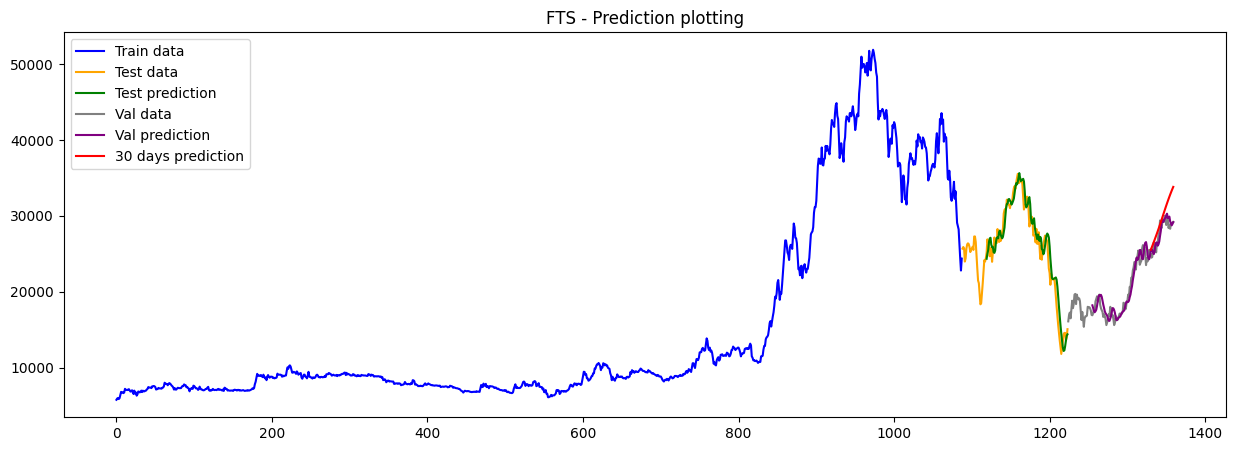

In [112]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [113]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


- Split Price data
- Reset index

In [114]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [116]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


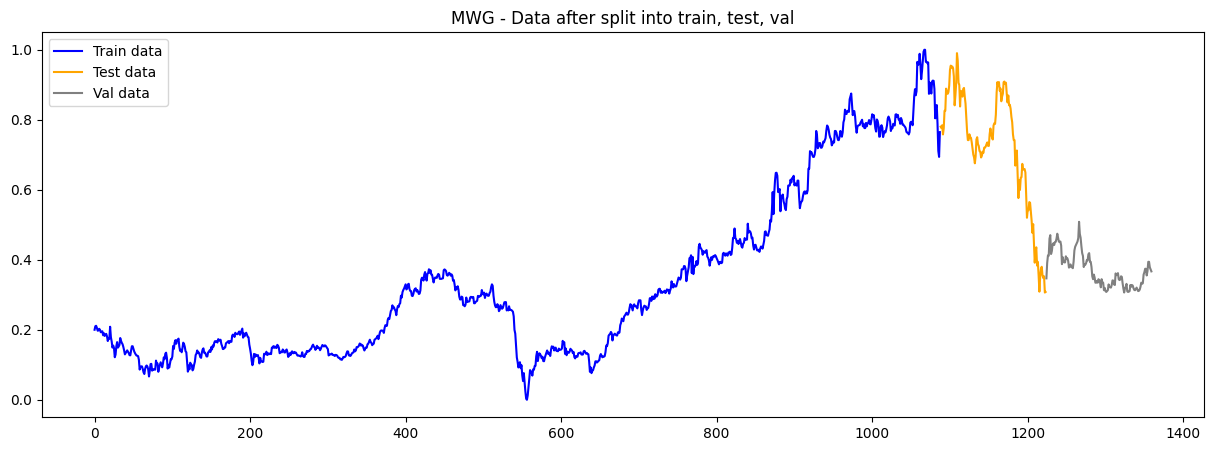

In [117]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [118]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [119]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [120]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [121]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(x_val.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(25))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [122]:
model_lstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 8s 144ms/step - loss: 0.0399 - val_loss: 0.0379
Epoch 2/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 3/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0021 - val_loss: 0.0123
Epoch 4/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 5/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0016 - val_loss: 0.0138
Epoch 6/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0015 - val_loss: 0.0169
Epoch 7/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0015 - val_loss: 0.0130
Epoch 8/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0015 - val_loss: 0.0142
Epoch 9/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 0.0111
Epoch 10/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 0.012

- Model Prediction on test, val (one-step prediction):

In [123]:
y_pred_test = model_lstm.predict(x_test)
y_pred_val = model_lstm.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 11ms/step


- 30 days prediction:

In [124]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_lstm.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [125]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[38630.71 ],
       [38676.363],
       [38821.867],
       [39030.14 ],
       [39273.332],
       [39534.668],
       [39806.734],
       [40083.594],
       [40361.168],
       [40635.75 ],
       [40904.43 ],
       [41166.07 ],
       [41419.664],
       [41663.695],
       [41895.754],
       [42118.773],
       [42332.65 ],
       [42538.055],
       [42737.58 ],
       [42931.527],
       [43121.348],
       [43308.316],
       [43494.773],
       [43682.984],
       [43873.96 ],
       [44068.77 ],
       [44267.33 ],
       [44471.113],
       [44680.535],
       [44897.676]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [126]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 62267.7153
Validating RMSE: 41446.8499
Predicting 30 days RMSE: 41859.2524

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 110.273
Validating MSLE: 106.5703
Predicting 30 days MSLE: 107.0809


- Prediction plotting:

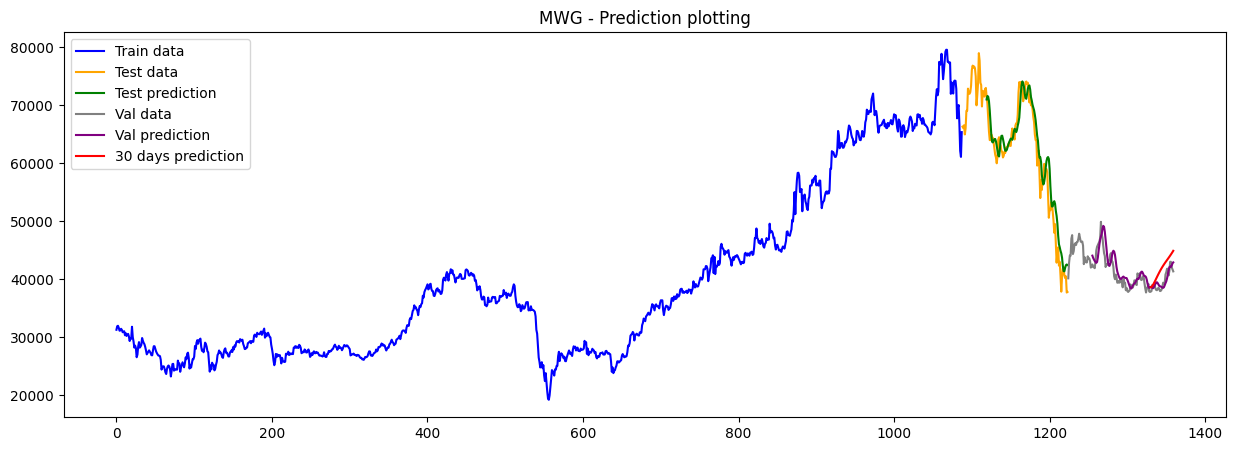

In [127]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [128]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [129]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [130]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [131]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


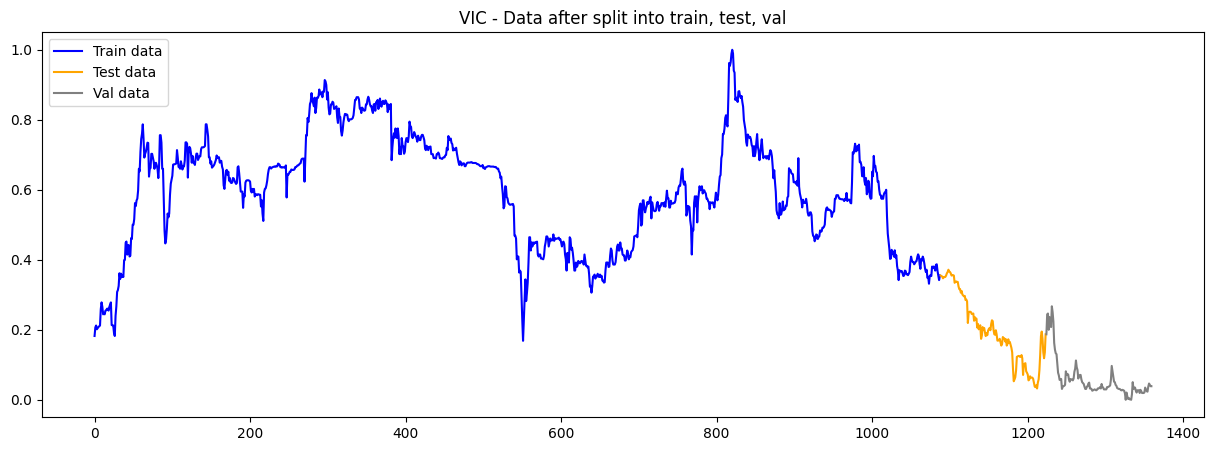

In [132]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [133]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [134]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [135]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [136]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(x_val.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(25))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error',optimizer='adam')

In [137]:
model_lstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 127ms/step - loss: 0.1131 - val_loss: 0.0121
Epoch 2/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0115 - val_loss: 0.0364
Epoch 3/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0071 - val_loss: 0.0271
Epoch 4/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0058 - val_loss: 0.0184
Epoch 5/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0051 - val_loss: 0.0137
Epoch 6/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0047 - val_loss: 0.0099
Epoch 7/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 8/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0042 - val_loss: 0.0056
Epoch 9/100
17/17 [==============================] - 1s 41ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 10/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0039 - val_loss: 0.004

- Model Prediction on test, val (one-step prediction):

In [138]:
y_pred_test = model_lstm.predict(x_test)
y_pred_val = model_lstm.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 10ms/step


- 30 days prediction:

In [139]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_lstm.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [140]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[56471.176],
       [56726.086],
       [57412.082],
       [58389.125],
       [59508.855],
       [60664.266],
       [61795.613],
       [62877.78 ],
       [63905.01 ],
       [64879.625],
       [65805.4  ],
       [66686.664],
       [67527.13 ],
       [68330.08 ],
       [69098.37 ],
       [69834.79 ],
       [70541.84 ],
       [71221.79 ],
       [71876.42 ],
       [72507.24 ],
       [73115.37 ],
       [73701.69 ],
       [74266.93 ],
       [74811.67 ],
       [75336.49 ],
       [75841.984],
       [76328.83 ],
       [76797.836],
       [77249.57 ],
       [77685.01 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [141]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 65713.4754
Validating RMSE: 57988.5216
Predicting 30 days RMSE: 68695.8118

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 119.7525
Validating MSLE: 119.4771
Predicting 30 days MSLE: 123.2771


- Prediction plotting:

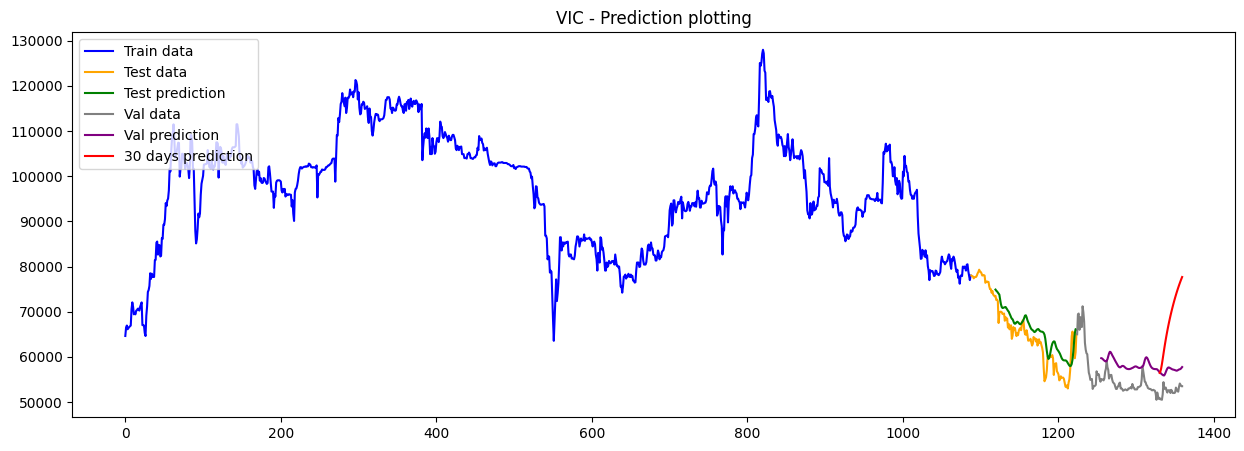

In [142]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()